In [3]:
# %%
import numpy as np
#import scipy as spy
import scipy.integrate as integrate
import scipy.special as special
#from sympy import *
import matplotlib.pyplot as plt
# from py_functions import getalpha0

In [4]:
NN = 7 # no parallel acts
nnn = 7 # no series acts
test = [[[1,1],[2,1],[3,1]],[[4,1],[5,1],[6,1]]]
print(np.shape(test))
cell_test = [None]*NN*nnn
cell_test[2] = test


(2, 3, 2)


109.14644739904533
2.8285934657706626
109.14644739904533
5.657186931541325
109.14644739904533
8.447557706340671
109.14644739904533
11.200908710950396
109.14644739904533
13.918420058985562
109.14644739904533
16.601026933409994
109.14644739904533
19.24986940415347


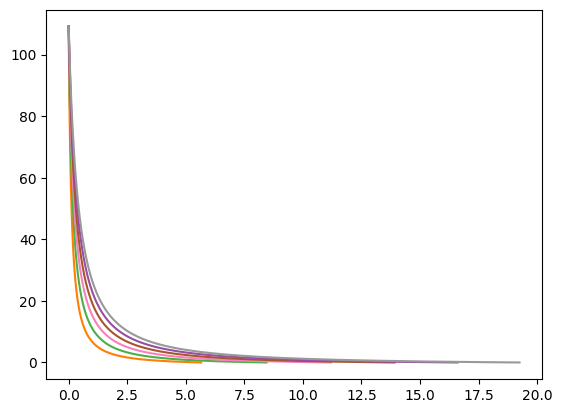

In [5]:
maxF = np.ones((NN*nnn,1))
maxx = np.ones((NN*nnn,1))
all_results = []

# %%
## Model Constants
Lp = 0.02 # [m] Initial Pouch Length - From original kellaris paper (2018)
perm0 = 8.85418782e-12#[m-3kg-1s4A2]
permr = 2.2 # for BOPP
Eb = 700e6 #[V/m] the breakdown strength of BOPP
w = 0.08 #[m] from original kellaris paper
t = 30e-6 #[m] Bopp thickness used in initial designs
k = 1000000 #[Nm-1] Achilles tendon average sourced from Litchwark 2005
rho_f = 903 #[kgm-3] Bopp Density TEKRA (2020)
rho_o = 920 #[kgm-3] FR3 Dielectric oil Density Cargill (2018)
alpf = np.pi/2 #[rad] Assume circular cross section on stroke completion
Eper = 0.6 # Percentage of electrode coverage
Va = 10000 # Actuation voltage
N = 1
nn = nnn # Number of series acutators
res = 20000

# %%
## Swept constants
#Va = np.linspace(0,10000,1000) # 0 -> 10kV res: 10V
E = Va/(2*t)
#Eper = np.linspace(0,1,0.01)

## model start
#Lambda for force
lamb = N*Va**2*perm0*permr*w/(4*t)

# Electrode length
Le = Lp*Eper

#optimal fill eqn based on electrode coverage ratio
# !!! MIGHT NOT WORK WITH ARRAY !!!
alpeqn = ((1-Eper)**2)*(2/np.pi) # Easy to calc constant
y = 0.01 # intial guess of angle
it = 0.0001 # iteration
scale = 1.6/it # how many possible
end = int(scale) # int for loop
for i in range(0,end): # over scale
    
    func = (y-np.sin(y)*np.cos(y))/(y**2) - alpeqn # Find value of remaining equation with embedded alpha0
    
    if func >= 0: # root is transition from negative to positive in this case
        alp0 = y - it # previous value before sign flip returned       
        break #root found, stop
    else:
        y += it #move to next guess
        continue


#Height
h = Lp*(np.sin(alp0)/alp0) # Height [m]

#Area w/ restraints 
# !!! MIGHT NOT WORK WITH ARRAY !!!
A = (Lp - Le)**2 /np.pi # Area [m2]
#Fill Volume 
Vol = A*w
#Blocking force
Fb = (lamb)*(np.cos(alp0)/(1-np.cos(alp0)))

Lpf = Lp - Le # Fully Deformed pouch length 

xmax = h - (Lpf*(np.sin(alpf)/alpf)) - Le # max displacement


alp = np.linspace(alp0,alpf,res) #sweep alpha and SET RESOLUTION

# Blocks of lp(alp) eqn sweep
lpnum = 2*A*np.square(alp)
lpdom = (alp - np.sin(alp)*np.cos(alp))
lp2 = lpnum/lpdom
lp = lp2**0.5
lp[0] = Lp # Removes unphysical discretisation error

# electrode length sweep
le = Lp - lp 

# displacement sweep
lpmp = np.sin(alp)/alp # lp multiplier in x
lplpmp = lp*lpmp
X = h - lplpmp - le

# Load of spring
P = k*X

# Force output of actuator
F = lamb*(np.cos(alp)/(1-np.cos(alp)))

# fig, ax = plt.subplots()
# ax.plot(X*1000, F)
# plt.xlabel(r"Tip Displacment $[mm]$")
# plt.ylabel(r"Maximum Load $[N]$")
# plt.title("Series Scaling test")
# %%
# For each actuator in series the load experienced for a given stroke is increased 
# by the mass of the actuators below it.
# All share the same blocking force 
# F - X Defines single actuator dynamics and are used to build series dynamics
out = [None]*4
f_normal = F/(w*t*perm0*permr*E*E) # Normalise force as per Kellaris 2019
strain = (X/(Lp*1))*100 # Calculate Strain
out[0] = X# Stack results for storage
out[1] = F
out[2] = strain 
out[3] = f_normal
maxF[0] = max(F)
maxx[0] = max(X*1000)
print(max(F))
print(max(X*1000))
all_results.append(out)
globalx = X # starts at full X as it will deform for sure as it did for single actuator
#addload = (nn-1)*9.81*(Vol*rho_o+Lp*w*t*2*rho_f) # additional load from actuators below current (nn)
#Look at load value 
xseries = np.zeros((nnn,res))
mass = np.zeros((nnn,res))
check1 = np.zeros((nnn,res))
check2 = np.zeros((nnn,res))
xseries[0,:] = X

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                '#f781bf', '#a65628', '#984ea3',
                '#999999', '#e41a1c', '#dede00']
fig, ax = plt.subplots() 
for nn in range(2,nnn+1):
    for n in range(1,nn): #for every actuator in series
        # print('actuator')
        # print('n= ' + str(n))
        addload = N*(n-1)*9.81*(Vol*rho_o + Lp*w*t*2*rho_f)
        # print('addload|' + str(addload))
        for i in range(0,len(F)): # for each load value
        
            # print('load value')
            # print('i= ' + str(i))
            mass[n-1,i] = F[i] + addload  # establish an effective mass on single actuator FBD
            # print('mass|' + str(mass[n-1,i]))
            
            if mass[n-1,i] >= Fb: # If the actuator is blocked, move on to next load
                # print('Block|' +str(i) + ' ' + str(n))
                continue
            else: # the actuator can move but by how much?
                # the potential movement is given by graph in previous code
                # the place where the mass roughly equals force is the potential stroke of the actuator
                
                j=0
                while j  < len(F): # sweep F looking for cross point
                    
                    # We want to see the first point where mass > force as this gives us effective stroke
                    if F[j] <= mass[n-1,i]: # check above and if true insert the additional stroke                          
                        xseries[n,i] = X[j]  # Additional displacement at this point is added to global
                        break
                    else:
                        j+=1
                continue
    XX = np.sum(xseries, axis = 0) #sum additional x for each actuator (row)
    #Corresponding displacement
    #build into array for every force
    #add to global

    
    ax.plot(XX*1000,F, label = str(nn-1) + ' Actuator(s)', color = CB_color_cycle[nn-1])
    f_normal = F/(w*t*perm0*permr*E*E) # Normalise force as per Kellaris 2019
    strain = (XX/(Lp*nn))*100 # Calculate Strain
    out = [None]*4
    out[0] = XX# Stack results for storage
    out[1] = F
    print(max(F))
    print(max(XX*1000))
    out[2] = strain 
    out[3] = f_normal
    maxF[nn-1] = max(F)
    maxx[nn-1] = max(XX*1000)
    all_results.append(out)


In [6]:
## Parallel calculations - Literally just multiply force by N

# Pull the values for force from the array 
usethis = all_results[0]
print(max(all_results[0][1]))
Fusethis = usethis[1]
Fnormusethis = usethis[3]
# Multiply them by the appropriate value 
N = 1
for i in range(0,NN*(nnn-1)):
    print("N = "+ str(N))
    print(i % nnn)
    if i % nnn == 0:
        N += 1
    insert = all_results[i % nnn].copy()
   
    insert[1] = Fusethis*N
    insert[3] = Fnormusethis*N

    maxF[i+nnn] = max(F)
    maxx[i+nnn] = max(XX*1000)
   
    all_results.append(insert)
    
    
# Add in the right results slot 
print(max(all_results[0][1]))
        
     


109.14644739904533
N = 1
0
N = 2
1
N = 2
2
N = 2
3
N = 2
4


N = 2
5
N = 2
6
N = 2
0
N = 3
1
N = 3
2
N = 3
3
N = 3
4
N = 3
5
N = 3
6
N = 3
0
N = 4
1
N = 4
2
N = 4
3
N = 4
4
N = 4
5
N = 4
6
N = 4
0
N = 5
1
N = 5
2
N = 5
3
N = 5
4
N = 5
5
N = 5
6
N = 5
0
N = 6
1
N = 6
2
N = 6
3
N = 6
4
N = 6
5
N = 6
6
N = 6
0
N = 7
1
N = 7
2
N = 7
3
N = 7
4
N = 7
5
N = 7
6
109.14644739904533


In [7]:
print(len(all_results))

49


In [8]:
specific_eng = [None]*NN*nnn # Empty list to  store specific energies
for i in range(0,NN*nnn):
    
    F = all_results[i][1].copy()
    X = all_results[i][0].copy()    
    uuact = np.zeros(len(X))
    for j in range(0,res):
        uuact[j] = integrate.trapezoid(F[0:j],X[0:j]) # array of actuator energy till point
    specific_eng[i] = uuact



In [20]:
spring_ks = np.linspace(1000,1000000,res) # Lienar springs for block point finding. 
energys = [[None for j in range(res)] for i in range(NN*nnn)]
bigBlocks = np.zeros((NN*nnn,res))
# For each actuator
best = np.ones((NN*nnn,1))
best_blocks = np.ones((NN*nnn,1))
for i in range (0,NN*nnn):
    use = all_results[i].copy()
    x = use[0]
    f_act = use[1] 
    blocks = np.zeros((res,1),dtype=int)
    # For each spring, test and save block point 
    j = 0
    bestsofar = 0
    for k in spring_ks:
        for ii in range(0,res):
            eng = np.zeros((3,1)) # format is [uact,usee,ratio]
            if k*x[ii] >= f_act[ii]:
                bigBlocks[i][j] = ii
                eng[0] = integrate.trapezoid(f_act[0:ii],x[0:ii]) # Act Eng
                eng[1] = 0.5*k*x[ii]**2 # Spring Eng
                if eng[1] > bestsofar:
                    bestsofar = eng[1]
                    best[i] = j
                    best_blocks[i] = ii
                eng[2] = (eng[1]/eng[0])*100 # Energy storage ratio
                break 
            else:
                continue
        energys[i][j] = eng 
        j += 1
        
        
# Run through x, find block point, what is the energy? 


C:\Users\Harri\AppData\Local\Temp\ipykernel_23448\3293757754.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kindex = int(best[i])
C:\Users\Harri\AppData\Local\Temp\ipykernel_23448\3293757754.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index = int(best_blocks[i])


1956
0.19836032396789577
19.579569428799285
268
1.3735623752332715
19.761811880006224
1108
1.3881878532301835
78.22073094226786
13731
0.19894637062593984
136.65581333646
1954
1.3881878532301835
136.88529001566667


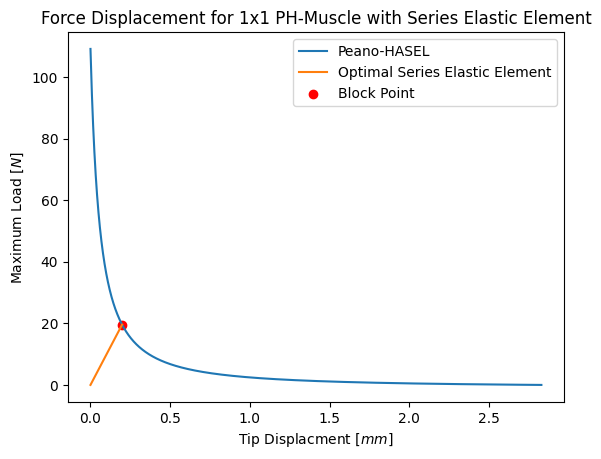

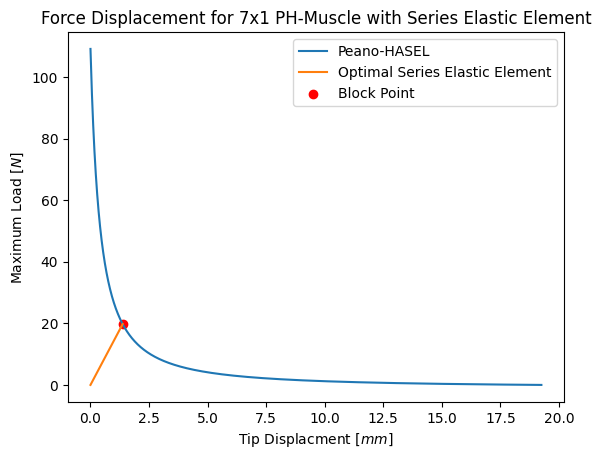

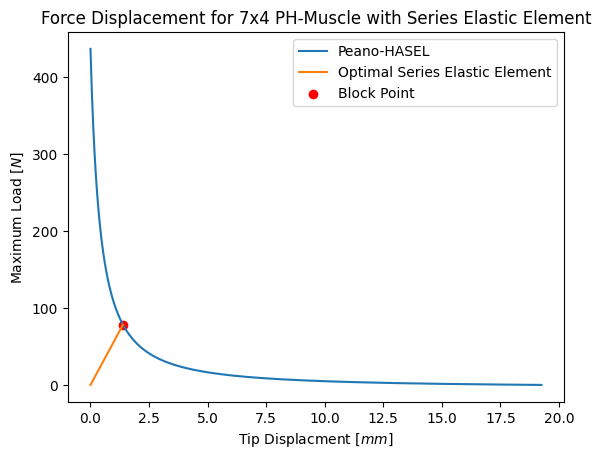

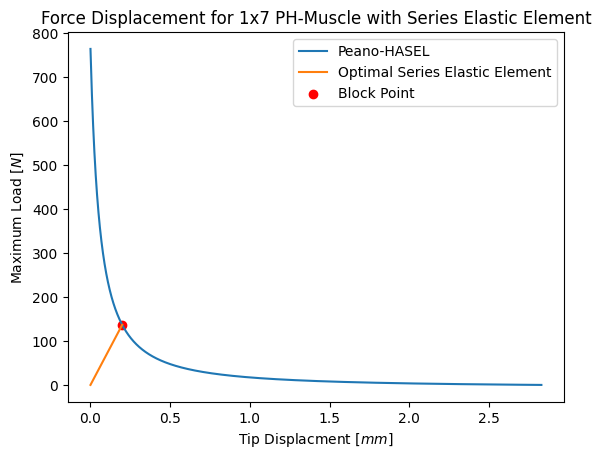

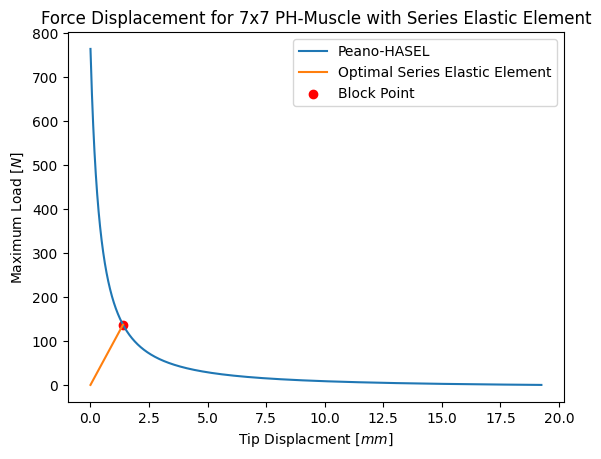

In [36]:
index_use = [0,6,27,42,48]
title_adds = ["1x1","7x1","7x4","1x7","7x7"]
ii = 0

for i in index_use:
    fig, ax = plt.subplots() # Make a figure
    # Plot the f-x
    use = all_results[i].copy()
    F = use[1]
    X = use[0]
    ax.plot(X*1000, F,label="Peano-HASEL")
    plt.xlabel(r"Tip Displacment $[mm]$")
    plt.ylabel(r"Maximum Load $[N]$")
    plt.title(f"Force Displacement for {title_adds[ii]} PH-Muscle with Series Elastic Element")
    
    ii += 1
    kindex = int(best[i])
    print(kindex)
    k = spring_ks[kindex]
    index = int(best_blocks[i])
    s_f = k*X[0:index]
    ax.plot(X[0:index]*1000, s_f,label = "Optimal Series Elastic Element")
    ax.scatter(X[index-1]*1000,s_f[index-1],c = "r",label="Block Point")
    print(X[index-1]*1000)
    print(s_f[index-1])
    ax.legend()
    # Plot all springs
    # make a figure
    # plot usee, percentage, spring graph for all 
    
    


1x1


1956
7x1
268
7x4
1108
1x7
13731
7x7
1954


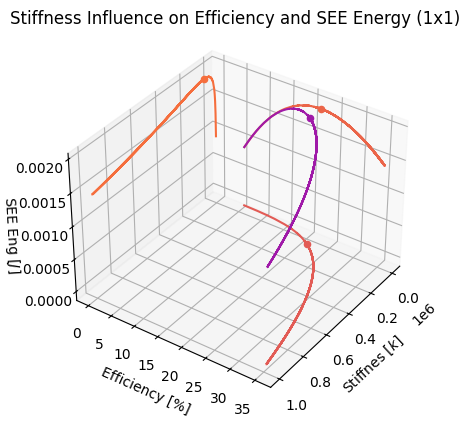

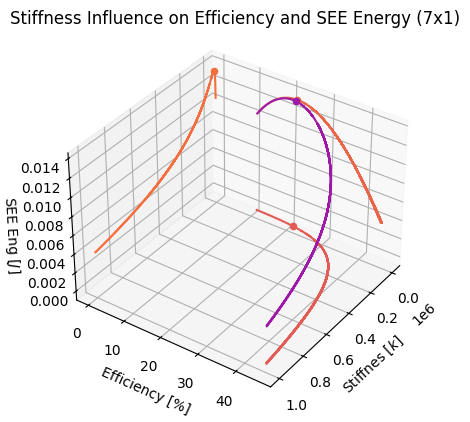

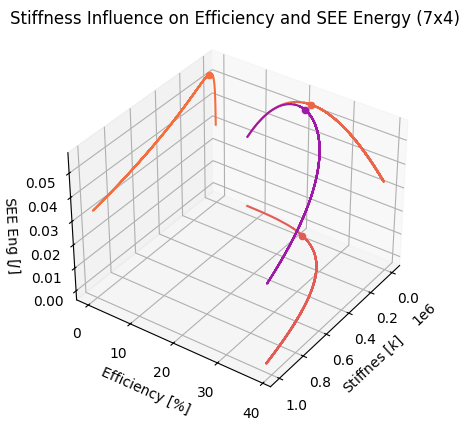

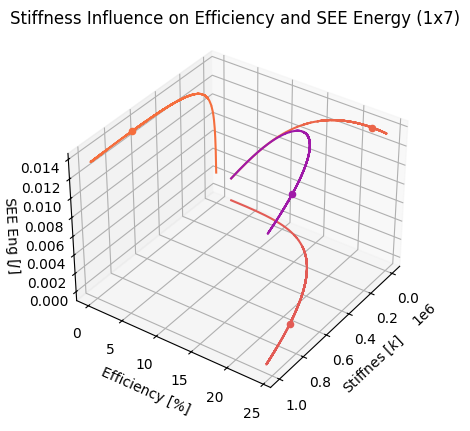

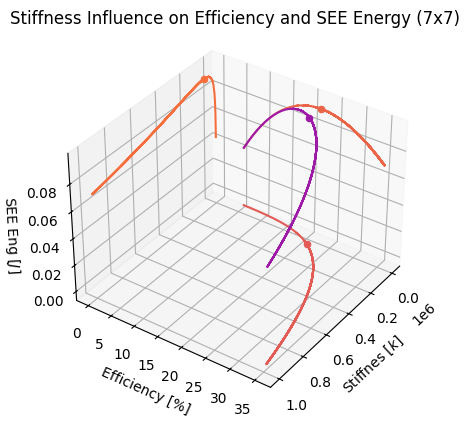

In [11]:
## Energy Graphs
x = spring_ks
index_use = [0,6,27,42,48]
title_adds = ["1x1","7x1","7x4","1x7","7x7"]
ii = 0
bestj = 0
for i in index_use:
    print(title_adds[ii])
    bestsofar = 0
    use_this = energys[i][:].copy() 
    # Make usee and eff arrays
    usee = np.zeros((res,1))
    eff = np.zeros((res,1))
    for j in range(0,res):
        usee[j] = use_this[j][1]
        eff[j] = use_this[j][2]       
    for j in range(0,res):
        if usee[j] > bestsofar:
            bestsofar = usee[j]
            bestj = j
        else:
            continue   
    print(bestj)
    fig= plt.figure()
    y= eff
    z= usee
    ax= fig.add_subplot(111, projection= '3d')
    ax.plot(x, z, '#f56e3d', zdir='y')
    ax.plot(y, z, '#eb6549', zdir='x')
    ax.plot(x, y, '#e25b55'  ,zdir='z')
   
    ax.scatter(x[bestj], z[bestj], color='#f56e3d', zdir='y')
    ax.scatter(y[bestj], z[bestj],color= '#eb6549', zdir='x')
    ax.scatter(x[bestj], y[bestj], color='#e25b55'  ,zdir='z')
    ax.plot(x.flatten(),y.flatten(),z.flatten(),color = '#9f19a8')
    ax.scatter(x[bestj],y[bestj],z[bestj],color='#9f19a8')
    ax.set_xlabel("Stiffnes "r"[$k$]")
    ax.set_ylabel("Efficiency "r"[%]")
    ax.set_zlabel("SEE Eng " r"[$J$]")
    plt.title(f"Stiffness Influence on Efficiency and SEE Energy ({title_adds[ii]})")
    ii += 1

    ax.view_init(35, 35)

[[ 1  2  3  4  5  6  7]
 [ 2  4  6  8 10 12 14]
 [ 3  6  9 12 15 18 21]
 [ 4  8 12 16 20 24 28]
 [ 5 10 15 20 25 30 35]
 [ 6 12 18 24 30 36 42]
 [ 7 14 21 28 35 42 49]]
[[9.8259879  9.8259879  9.8259879  9.8259879  9.8259879  9.8259879
  9.8259879 ]
 [9.8259879  9.8259879  9.8259879  9.8259879  9.8259879  9.8259879
  9.8259879 ]
 [9.81749099 9.81749099 9.81749099 9.81749099 9.81749099 9.81749099
  9.81749099]
 [9.80655002 9.80655002 9.80655002 9.80655002 9.80655002 9.80655002
  9.80655002]
 [9.79464764 9.79464764 9.79464764 9.79464764 9.79464764 9.79464764
  9.79464764]
 [9.78229849 9.78229849 9.78229849 9.78229849 9.78229849 9.78229849
  9.78229849]
 [9.76972907 9.76972907 9.76972907 9.76972907 9.76972907 9.76972907
  9.76972907]]


C:\Users\Harri\AppData\Local\Temp\ipykernel_23448\599126325.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+labs)
C:\Users\Harri\AppData\Local\Temp\ipykernel_23448\599126325.py:34: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+labs)


[Text(0, -1.0, ''),
 Text(0, 0.0, '1'),
 Text(0, 1.0, '2'),
 Text(0, 2.0, '3'),
 Text(0, 3.0, '4'),
 Text(0, 4.0, '5'),
 Text(0, 5.0, '6'),
 Text(0, 6.0, '7'),
 Text(0, 7.0, '')]

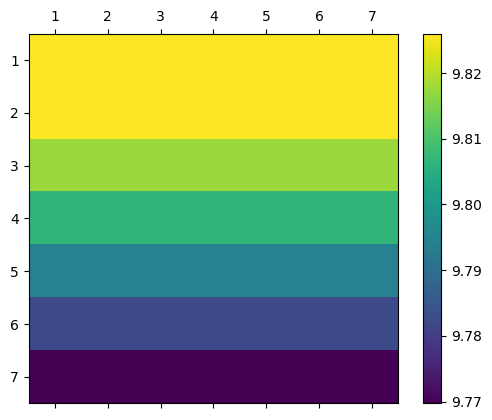

In [12]:

## Specific Energy scaling
# masses
rng1 = np.arange(1, NN+1)
rng2 = np.arange(1, nnn+1)
masses = rng1 * rng2[:, None] # init array for number of actuators
print(masses)
ph_mass = Vol*rho_o + Lp*w*t*2*rho_f
masses = masses*ph_mass

# Energ
act_energies = np.zeros((nnn,NN))
eng = integrate.trapezoid(f_act,x)
j = -1
k = 0
for i in range(0,NN*nnn): # go through results
    use = all_results[i].copy()
    x = use[0]
    f_act = use[1] 
    if i % nnn == 0: # add a column bump every nnn
        j += 1 # bump col
        k = 0 # reset row
    act_energies[k][j] = integrate.trapezoid(f_act,x)/masses[k][j]
    
    k += 1
print(act_energies)


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(act_energies, interpolation='nearest')
fig.colorbar(cax)
labs = ["1","2","3","4","5","6","7"]
ax.set_xticklabels(['']+labs)
ax.set_yticklabels(['']+labs)


C:\Users\Harri\AppData\Local\Temp\ipykernel_23448\2896408700.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+labs)
C:\Users\Harri\AppData\Local\Temp\ipykernel_23448\2896408700.py:27: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+labs)
C:\Users\Harri\AppData\Local\Temp\ipykernel_23448\2896408700.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['']+labs)
C:\Users\Harri\AppData\Local\Temp\ipykernel_23448\2896408700.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(['']+labs)
C:\Users\Harri\AppData\Local\Temp\ipykernel_23448\2896408700.py:44: UserWarning: set_tic

[Text(0, -1.0, ''),
 Text(0, 0.0, '1'),
 Text(0, 1.0, '2'),
 Text(0, 2.0, '3'),
 Text(0, 3.0, '4'),
 Text(0, 4.0, '5'),
 Text(0, 5.0, '6'),
 Text(0, 6.0, '7'),
 Text(0, 7.0, '')]

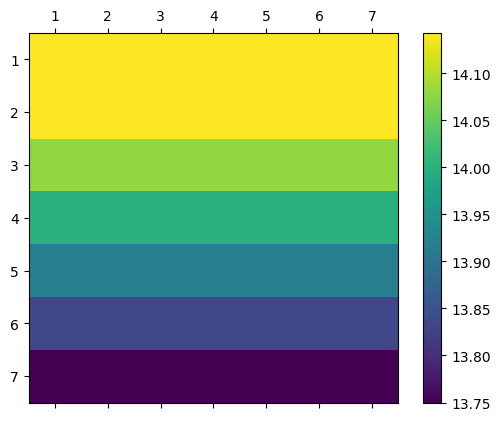

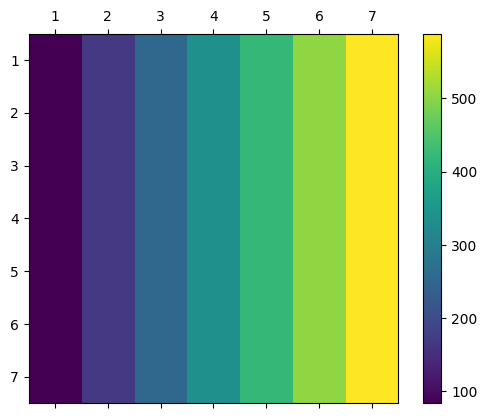

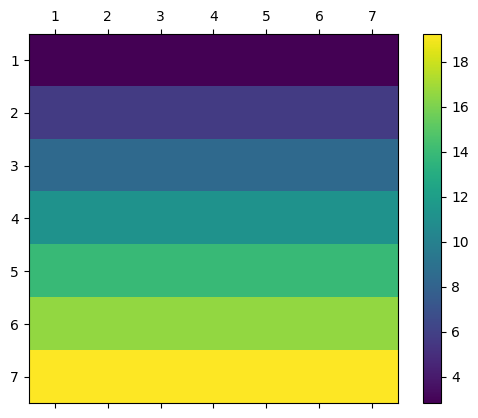

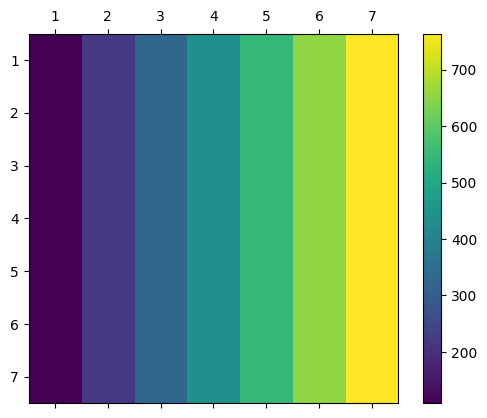

In [13]:
max_strain = np.zeros((nn,N))
max_norm = np.zeros((nn,N))
max_disp = np.zeros((nn,N))
max_f = np.zeros((nn,N))
j = -1
for i in range(0,NN*nnn): # go through results
    use = all_results[i].copy()
    x = use[0]
    f = use[1]
    strain = use[2]
    f_norm = use[3] 
    if i % nnn == 0: # add a column bump every 7
        j += 1 # bump col
        k = 0 # reset row
    max_strain[k][j] = max(strain)
    max_norm[k][j] = max(f_norm)
    max_disp[k][j] = max(x)
    max_f[k][j] = max(f)
    k += 1

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(max_strain, interpolation='nearest')
fig.colorbar(cax)
labs = ["1","2","3","4","5","6","7"]
ax.set_xticklabels(['']+labs)
ax.set_yticklabels(['']+labs)


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(max_norm, interpolation='nearest')
fig.colorbar(cax)
labs = ["1","2","3","4","5","6","7"]
ax.set_xticklabels(['']+labs)
ax.set_yticklabels(['']+labs)


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(max_disp*1000, interpolation='nearest')
fig.colorbar(cax)
labs = ["1","2","3","4","5","6","7"]
ax.set_xticklabels(['']+labs)
ax.set_yticklabels(['']+labs)


fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(max_f, interpolation='nearest')
fig.colorbar(cax)
labs = ["1","2","3","4","5","6","7"]
ax.set_xticklabels(['']+labs)
ax.set_yticklabels(['']+labs)

   

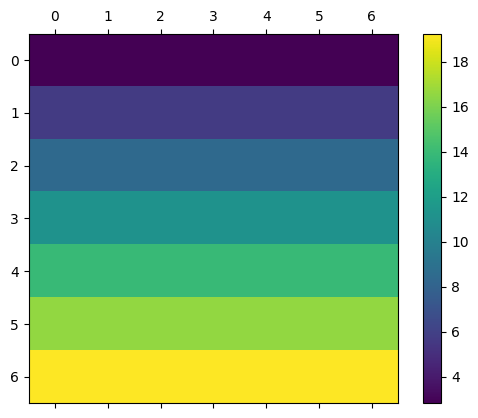

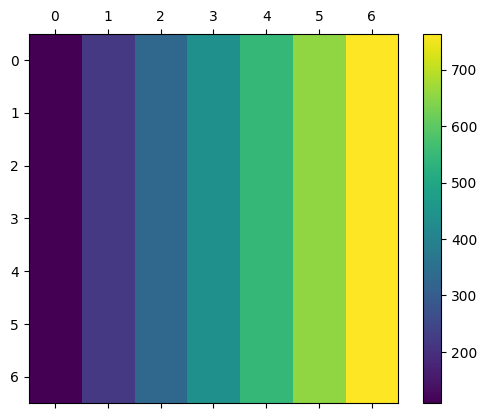

In [14]:
max_strain = np.zeros((nn,N))
max_norm = np.zeros((nn,N))
j = -1
for i in range(0,NN*nnn): # go through results
    use = all_results[i].copy()
    strain = use[0]*1000
    f_norm = use[1] 
    if i % nnn == 0: # add a column bump every 7
        j += 1 # bump col
        k = 0 # reset row
    max_strain[k][j] = max(strain)
    max_norm[k][j] = max(f_norm)
    k += 1

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(max_strain, interpolation='nearest')
fig.colorbar(cax)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(max_norm, interpolation='nearest')
fig.colorbar(cax)
   

C:\Users\Harri\AppData\Local\Temp\ipykernel_23448\1235069777.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kindex = int(best[i])
C:\Users\Harri\AppData\Local\Temp\ipykernel_23448\1235069777.py:18: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index = int(best_blocks[i])


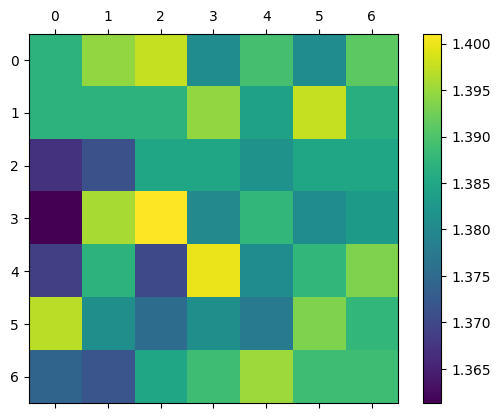

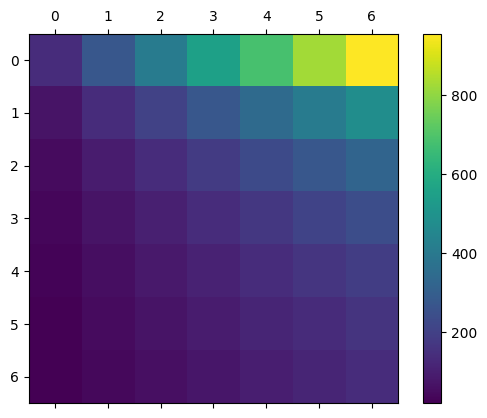

In [15]:
## Matrices of block point displacements and stiffnesses and SEE energy 
block_x = np.zeros((nn,N))
block_f = np.zeros((nn,N))
block_effs = np.zeros((nn,N))
block_energies = np.zeros((nn,N))
j = -1
kk = 0
for i in range(0,NN*nnn): # go through results
    use = all_results[i].copy()
    x = use[0]
    f_act = use[1] 
    if i % nnn == 0: # add a column bump every 7
        j += 1 # bump col
        kk = 0 # reset row
    
    kindex = int(best[i])
    k = spring_ks[kindex]
    index = int(best_blocks[i])
    
    block_x[kk][j] = X[index]*1000
    block_f[kk][j] = k*X[index]
    
    kk += 1

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(block_x, interpolation='nearest')
fig.colorbar(cax)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(block_f, interpolation='nearest')
fig.colorbar(cax)

C:\Users\Harri\AppData\Local\Temp\ipykernel_23448\695382060.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kindex = int(best[i])
C:\Users\Harri\AppData\Local\Temp\ipykernel_23448\695382060.py:20: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index = int(best_blocks[i])


493
386
305


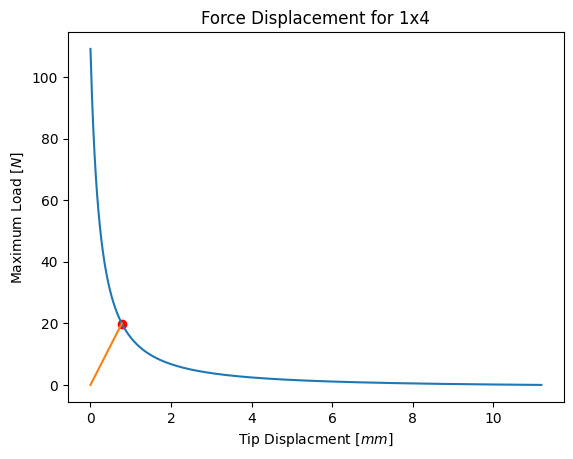

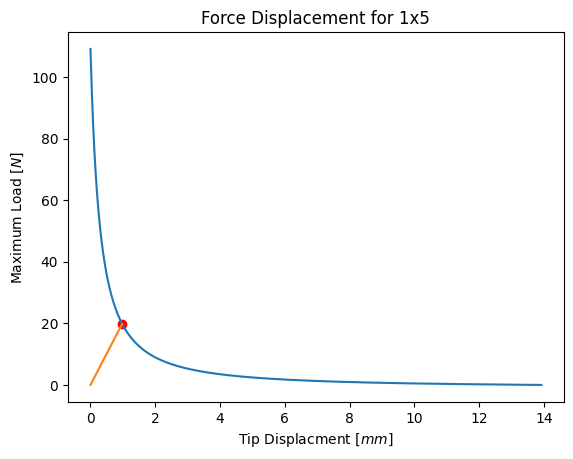

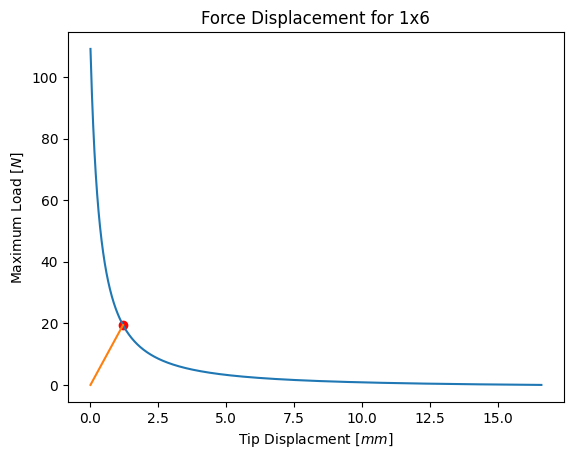

In [16]:
# Look at 3,4,5 

index_use = [3,4,5]
title_adds = ["1x4","1x5","1x6"]
ii = 0
for i in index_use:
    fig, ax = plt.subplots() # Make a figure
    # Plot the f-x
    use = all_results[i].copy()
    F = use[1]
    X = use[0]
    ax.plot(X*1000, F)
    plt.xlabel(r"Tip Displacment $[mm]$")
    plt.ylabel(r"Maximum Load $[N]$")
    plt.title(f"Force Displacement for {title_adds[ii]}")
    ii += 1
    kindex = int(best[i])
    print(kindex)
    k = spring_ks[kindex]
    index = int(best_blocks[i])
    s_f = k*X[0:index]
    ax.plot(X[0:index]*1000, s_f)
    ax.scatter(X[index-1]*1000,s_f[index-1],c = "r")
    # Plot all springs
    # make a figure
    # plot usee, percentage, spring graph for all 

In [17]:
def numpy_to_latex(matrix):
    # Start with the LaTeX matrix structure
    latex_matrix = "\\begin{bmatrix}\n"
    
    # Loop through each row of the matrix
    for row in matrix:
        # Join the row elements with '&' and add a '\\' at the end of each row for LaTeX formatting
        latex_matrix += " & ".join(map(str, row)) + " \\\\\n"
    
    # Close the LaTeX matrix structure
    latex_matrix += "\\end{bmatrix}"
    
    return latex_matrix

# Example usage
matrix = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
latex_output = numpy_to_latex(matrix)
print(latex_output)

\begin{bmatrix}
1 & 2 & 3 \\
4 & 5 & 6 \\
7 & 8 & 9 \\
\end{bmatrix}


1x1
1956
7x1
268
7x4
1108
1x7
13731
7x7
1954


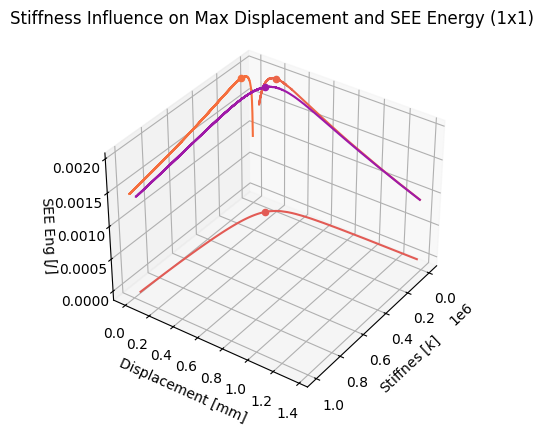

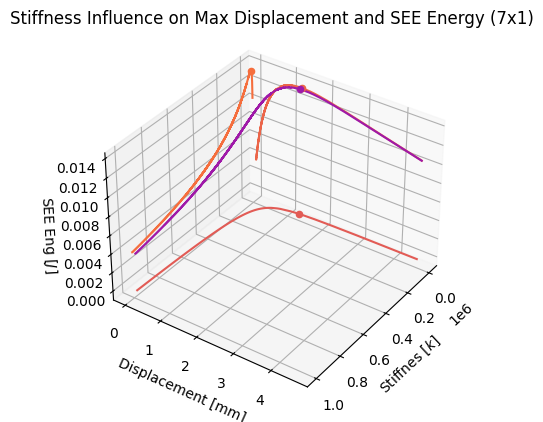

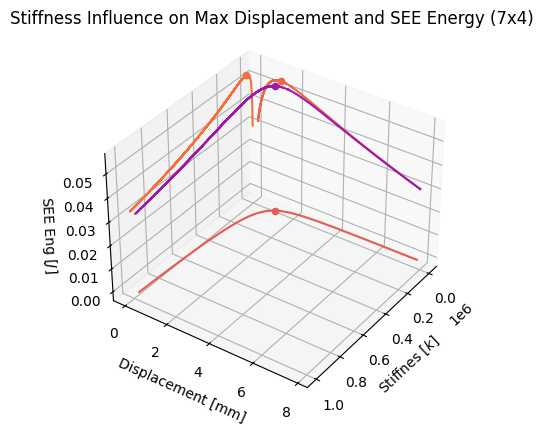

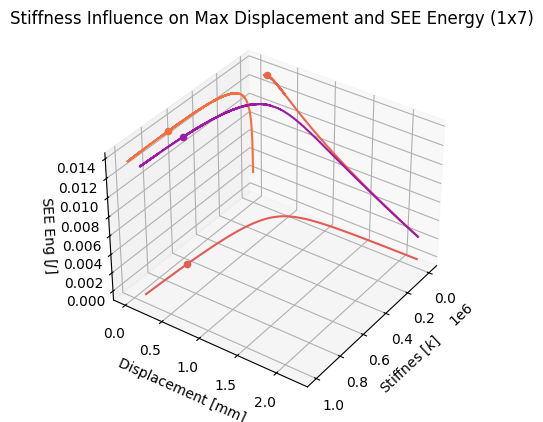

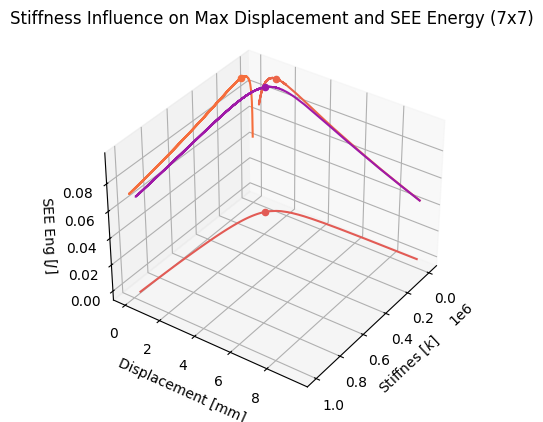

In [40]:
## Displacement, see energy, stiffness
## Energy Graphs
x = spring_ks
index_use = [0,6,27,42,48]
title_adds = ["1x1","7x1","7x4","1x7","7x7"]
ii = 0
bestj = 0
for i in index_use:
    print(title_adds[ii])
    bestsofar = 0
    use = all_results[i].copy()
    # F = use[1]
    X = use[0]
    use_this1 = energys[i][:].copy() 
    use_this2 = bigBlocks[i][:].copy()
    
    # Make usee and eff arrays
    usee = np.zeros((res,1))
    eff = np.zeros((res,1))
    for j in range(0,res):
        usee[j] = use_this1[j][1]
        eff[j] = X[int(use_this2[j])]*1000
            
    for j in range(0,res):
        if usee[j] > bestsofar:
            bestsofar = usee[j]
            bestj = j
        else:
            continue   
    print(bestj)
    fig= plt.figure()
    y= eff
    z= usee
    ax= fig.add_subplot(111, projection= '3d')
    ax.plot(x, z, '#f56e3d', zdir='y')
    ax.plot(y, z, '#eb6549', zdir='x')
    ax.plot(x, y, '#e25b55'  ,zdir='z')
   
    ax.scatter(x[bestj], z[bestj], color='#f56e3d', zdir='y')
    ax.scatter(y[bestj], z[bestj],color= '#eb6549', zdir='x')
    ax.scatter(x[bestj], y[bestj], color='#e25b55'  ,zdir='z')
    ax.plot(x.flatten(),y.flatten(),z.flatten(),color = '#9f19a8')
    ax.scatter(x[bestj],y[bestj],z[bestj],color='#9f19a8')
    ax.set_xlabel("Stiffnes "r"[$k$]")
    ax.set_ylabel("Displacement "r"[mm]")
    ax.set_zlabel("SEE Eng " r"[$J$]")
    plt.title(f"Stiffness Influence on Max Displacement and SEE Energy ({title_adds[ii]})")
    ii += 1

    ax.view_init(35, 35)

1x1
1956
7x1
268
7x4
1108
1x7
13731
7x7
1954


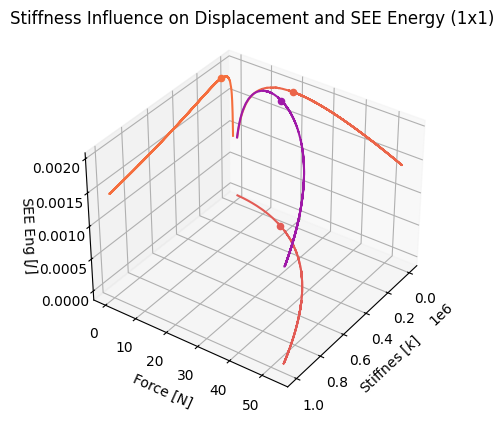

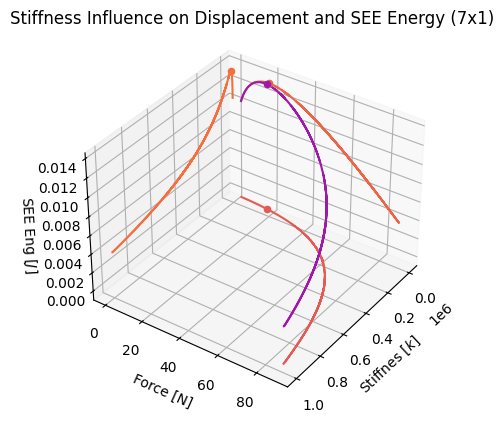

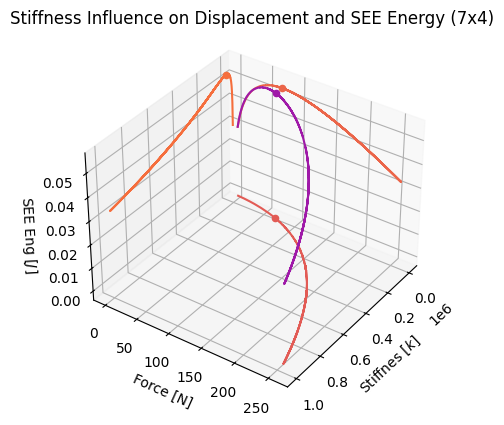

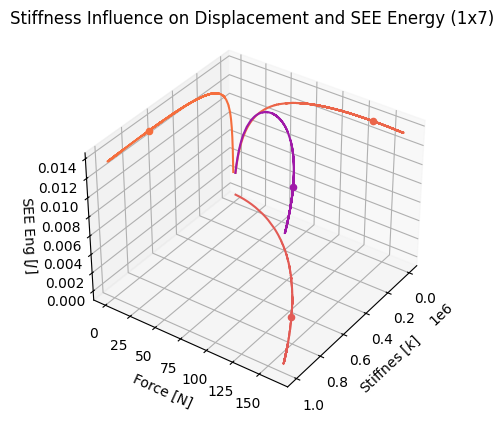

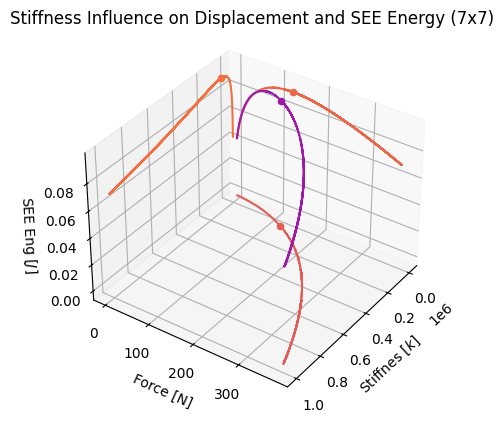

In [39]:
## Displacement, see energy, stiffness
## Energy Graphs
x = spring_ks
index_use = [0,6,27,42,48]
title_adds = ["1x1","7x1","7x4","1x7","7x7"]
ii = 0
bestj = 0
for i in index_use:
    print(title_adds[ii])
    bestsofar = 0
    use = all_results[i].copy()
    X = use[1]
    # X = use[0]
    use_this1 = energys[i][:].copy() 
    use_this2 = bigBlocks[i][:].copy()
    
    # Make usee and eff arrays
    usee = np.zeros((res,1))
    eff = np.zeros((res,1))
    for j in range(0,res):
        usee[j] = use_this1[j][1]
        eff[j] = X[int(use_this2[j])]
            
    for j in range(0,res):
        if usee[j] > bestsofar:
            bestsofar = usee[j]
            bestj = j
        else:
            continue   
    print(bestj)
    fig= plt.figure()
    y= eff
    z= usee
    ax= fig.add_subplot(111, projection= '3d')
    ax.plot(x, z, '#f56e3d', zdir='y')
    ax.plot(y, z, '#eb6549', zdir='x')
    ax.plot(x, y, '#e25b55'  ,zdir='z')
   
    ax.scatter(x[bestj], z[bestj], color='#f56e3d', zdir='y')
    ax.scatter(y[bestj], z[bestj],color= '#eb6549', zdir='x')
    ax.scatter(x[bestj], y[bestj], color='#e25b55'  ,zdir='z')
    ax.plot(x.flatten(),y.flatten(),z.flatten(),color = '#9f19a8')
    ax.scatter(x[bestj],y[bestj],z[bestj],color='#9f19a8')
    ax.set_xlabel("Stiffnes "r"[$k$]")
    ax.set_ylabel("Force "r"[N]")
    ax.set_zlabel("SEE Eng " r"[$J$]")
    plt.title(f"Stiffness Influence on Blocking Force and SEE Energy ({title_adds[ii]})")
    ii += 1

    ax.view_init(35, 35)

In [51]:
# For each muscle 
max_strain = np.zeros((nnn*NN))
max_norm = np.zeros((nnn*NN))
max_disp = np.zeros((nnn*NN))
max_f = np.zeros((nnn*NN))
best_k = np.zeros((nnn*NN))
spring_x = np.zeros((nnn*NN))
spring_f = np.zeros((nnn*NN))
effs =  np.zeros((nnn*NN))
usee =  np.zeros((nnn*NN))
j = -1
for i in range(0,NN*nnn): # go through results
    use = all_results[i].copy()
    x = use[0]
    f = use[1]
    strain = use[2]
    f_norm = use[3] 
    if i % nnn == 0: # add a column bump every 7
        j += 1 # bump col
        k = 0 # reset row
    max_strain[i] = max(strain)
    max_norm[i]  = max(f_norm)
    max_disp[i]  = max(x)*1000
    max_f[i] = max(f)
    kindex = int(best[i])

    best_k[i]= spring_ks[kindex]
    index = int(best_blocks[i])
    spring_f[i]= best_k[i]*x[index]
    spring_x[i]= x[index]*1000
    uact = integrate.trapezoid(f[0:index],x[0:index])
    usee[i] = 0.5*best_k[i]*x[index]**2
    effs[i] = (usee[i]/uact)*100
 

def signif(x, p):
    x = np.asarray(x)
    x_positive = np.where(np.isfinite(x) & (x != 0), np.abs(x), 10**(p-1))
    mags = 10 ** (p - 1 - np.floor(np.log10(x_positive)))
    return np.round(x * mags) / mags
    
import itertools

# Define the range for rows and columns (1 to 7)
rows = range(1, 8)
cols = range(1, 8)

# Use itertools.product to generate all combinations of rows and columns
row_labels = ["{}x{}".format(row, col) for row, col in itertools.product(rows, cols)]

headings1 = ["Max Disp [mm]","Max Force[mm]","Max Strain[\%]","Normalised Force"]

headings2 = ["Optimal Stiffness [N/m]","Displacement [mm]","Block Force [N]","Stored Energy [J]","Efficiency [%]"]
def arrays_to_latex_table(arrays, headings, row_labels=None):
    # Ensure all arrays have the same length
    num_rows = arrays[0].shape[0]
    for array in arrays:
        if array.shape[0] != num_rows:
            raise ValueError("All arrays must have the same number of rows")

    # If row_labels are provided, ensure they have the same length as the arrays
    if row_labels is not None and len(row_labels) != num_rows:
        raise ValueError("Row labels must have the same number of rows as the arrays")
    
    # If row labels are provided, adjust the LaTeX format to include them
    if row_labels is not None:
        latex_table = "\begin{longtable}{|c|""" + "|".join(["c"] * len(headings)) + "|}\n"
    else:
        latex_table = "\\begin{tabular}{" + "c" * len(headings) + "}\n"

    # Add headings to the table, prepending an empty cell if row labels are used
    if row_labels is not None:
        latex_table += " & " + " & ".join(headings) + " \\\\\n"
    else:
        latex_table += " & ".join(headings) + " \\\\\n"

    latex_table += "\\hline\n"

    # Loop through each row index and add corresponding values from row labels and arrays
    for i in range(num_rows):
        if row_labels is not None:
            row_values = [str(row_labels[i])] + [str(arr[i]) for arr in arrays]
        else:
            row_values = [str(arr[i]) for arr in arrays]

        latex_table += " & ".join(row_values) + " \\\\\n"

    # Close the LaTeX table structure
    latex_table += "\\end{longtable}"

    return latex_table

# Example usage
arr1 = [max_disp, max_f, max_strain, max_norm]
arr2 = [best_k,
        spring_x,
        spring_f,
        effs,
        usee]
p = 2
for arr in arr1:
    i = 0
    for x in arr:
        arr[i] = signif(x, p)
        i+=1
for arr in arr2:
    i = 0
    for x in arr:
        arr[i] = signif(x, p)
        i+=1
    

latex_output = arrays_to_latex_table(arr1, headings1, row_labels)
print(latex_output)

latex_output = arrays_to_latex_table(arr2, headings2, row_labels)
print(latex_output)

egin{longtable}{|c|c|c|c|c|}
 & Max Disp [mm] & Max Force[mm] & Max Strain[\%] & Normalised Force \\
\hline
1x1 & 2.8 & 110.0 & 14.0 & 84.0 \\
1x2 & 5.7 & 110.0 & 14.0 & 84.0 \\
1x3 & 8.4 & 110.0 & 14.0 & 84.0 \\
1x4 & 11.0 & 110.0 & 14.0 & 84.0 \\
1x5 & 14.0 & 110.0 & 14.0 & 84.0 \\
1x6 & 17.0 & 110.0 & 14.0 & 84.0 \\
1x7 & 19.0 & 110.0 & 14.0 & 84.0 \\
2x1 & 2.8 & 220.0 & 14.0 & 170.0 \\
2x2 & 5.7 & 220.0 & 14.0 & 170.0 \\
2x3 & 8.4 & 220.0 & 14.0 & 170.0 \\
2x4 & 11.0 & 220.0 & 14.0 & 170.0 \\
2x5 & 14.0 & 220.0 & 14.0 & 170.0 \\
2x6 & 17.0 & 220.0 & 14.0 & 170.0 \\
2x7 & 19.0 & 220.0 & 14.0 & 170.0 \\
3x1 & 2.8 & 330.0 & 14.0 & 250.0 \\
3x2 & 5.7 & 330.0 & 14.0 & 250.0 \\
3x3 & 8.4 & 330.0 & 14.0 & 250.0 \\
3x4 & 11.0 & 330.0 & 14.0 & 250.0 \\
3x5 & 14.0 & 330.0 & 14.0 & 250.0 \\
3x6 & 17.0 & 330.0 & 14.0 & 250.0 \\
3x7 & 19.0 & 330.0 & 14.0 & 250.0 \\
4x1 & 2.8 & 440.0 & 14.0 & 340.0 \\
4x2 & 5.7 & 440.0 & 14.0 & 340.0 \\
4x3 & 8.4 & 440.0 & 14.0 & 340.0 \\
4x4 & 11.0 & 440.0 & 1

<>:51: SyntaxWarning: invalid escape sequence '\%'
<>:51: SyntaxWarning: invalid escape sequence '\%'
C:\Users\Harri\AppData\Local\Temp\ipykernel_23448\3396013274.py:51: SyntaxWarning: invalid escape sequence '\%'
  headings1 = ["Max Disp [mm]","Max Force[mm]","Max Strain[\%]","Normalised Force"]
C:\Users\Harri\AppData\Local\Temp\ipykernel_23448\3396013274.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  kindex = int(best[i])
C:\Users\Harri\AppData\Local\Temp\ipykernel_23448\3396013274.py:28: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  index = int(best_blocks[i])


In [ ]:
## Optimum stiffness matrix for energy


## Optimum stiffness matric for displacement